In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nxcals.api.extraction.data.builders import *
from scipy.optimize import curve_fit
from datetime import datetime
def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()


In [13]:
start = "2023-04-20 11:00:00.000"
end = "2023-05-21 12:00:00.000"

In [14]:
# list of devices
devices = ["PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions",
           "PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions",
           "PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions",
           "PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions"]

dataframes = []  # to store the dataframes

# loop over devices
for i, device in enumerate(devices, 1):
    df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(device).build().toPandas()
    df = df.loc[df.selector == "CPS.USER.EAST3"]
    df['datetime'] = pd.to_datetime(df['acqStamp'], unit='ns')
    df.sort_values('datetime', inplace=True)
    
    # rename the columns for each device
    df.rename(columns={'HSigma': f'HSigma{i}', 'VSigma': f'VSigma{i}'}, inplace=True)
    
    dataframes.append(df)  # add dataframe to the list

# concat the dataframes
df_all = pd.concat(dataframes).sort_values('datetime')

# forward-fill and backward-fill NaN values
df_all.fillna(method='ffill', inplace=True)
df_all.fillna(method='bfill', inplace=True)


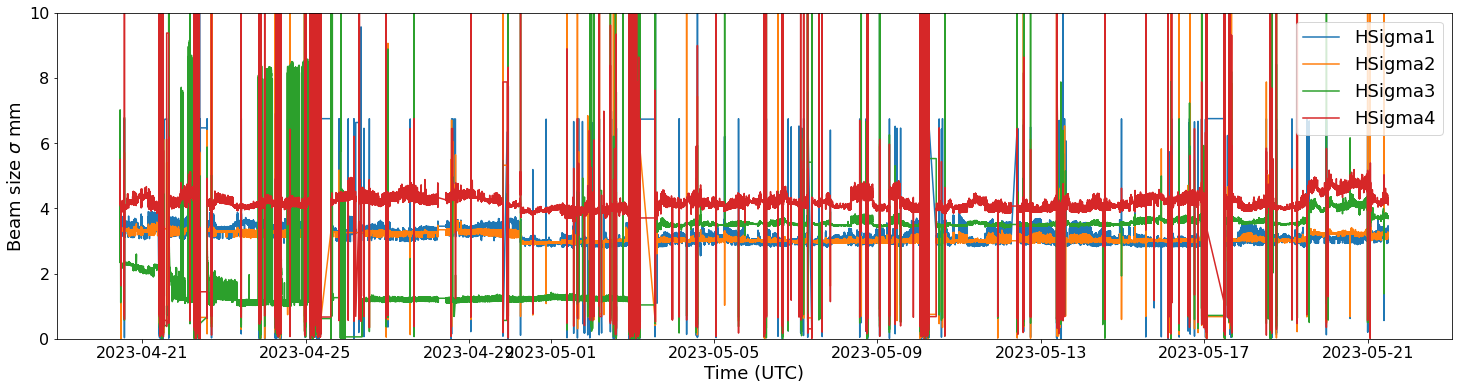

In [22]:
# Compute running averages with a window of size N
N = 100  # Set the window size to your desired value
df_all['HSigma1_avg'] = df_all['HSigma1'].rolling(window=N).mean()
df_all['HSigma2_avg'] = df_all['HSigma2'].rolling(window=N).mean()
df_all['HSigma3_avg'] = df_all['HSigma3'].rolling(window=N).mean()
df_all['HSigma4_avg'] = df_all['HSigma4'].rolling(window=N).mean()

# Create a plot
fig, ax = plt.subplots(figsize=(25,6))
ax.plot(df_all.datetime, df_all.HSigma1, label='HSigma1')
ax.plot(df_all.datetime, df_all.HSigma2, label='HSigma2')
ax.plot(df_all.datetime, df_all.HSigma3, label='HSigma3')
ax.plot(df_all.datetime, df_all.HSigma4, label='HSigma4')

# Add plots of running averages
# ax.plot(df_all.datetime, df_all.HSigma1_avg, label='HSigma1 Avg', linestyle='dashed')
# ax.plot(df_all.datetime, df_all.HSigma2_avg, label='HSigma2 Avg', linestyle='dashed')
# ax.plot(df_all.datetime, df_all.HSigma3_avg, label='HSigma3 Avg', linestyle='dashed')
# ax.plot(df_all.datetime, df_all.HSigma4_avg, label='HSigma4 Avg', linestyle='dashed')

ax.set_ylim(0,10)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Beam size $\sigma$ mm")
ax.legend(loc="upper right")
plt.show()

Text(0, 0.5, 'Beam size $\\sigma$ mm')

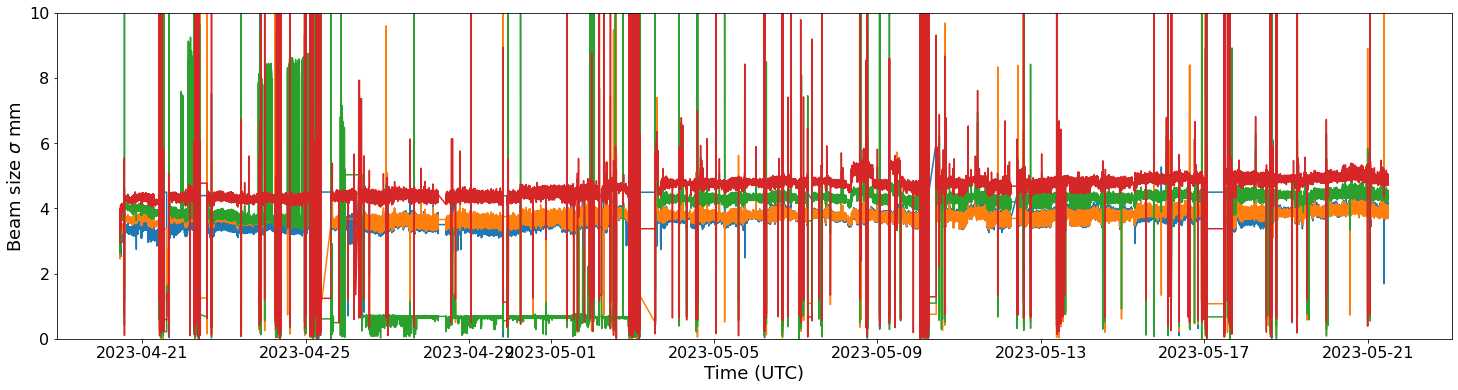

In [16]:
fig, ax = plt.subplots(figsize=(25,6))
ax.plot(df_all.datetime, df_all.VSigma1)
ax.plot(df_all.datetime, df_all.VSigma2)
ax.plot(df_all.datetime, df_all.VSigma3)
ax.plot(df_all.datetime, df_all.VSigma4)

ax.set_ylim(0,10)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Beam size $\sigma$ mm")